In [ ]:
# ========================
# 🔧 Manipulación de datos
# ========================
import pandas as pd
import numpy as np

# ========================
# 📊 Visualización
# ========================
import matplotlib.pyplot as plt
import seaborn as sns

# ========================
# 🧠 Machine Learning
# ========================
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# ========================
# ⚙️ TensorFlow / Keras
# ========================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Flatten, Concatenate,
    Dense, Dropout, BatchNormalization, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ========================
# 🧪 Utilidades
# ========================
import os
import warnings
warnings.filterwarnings("ignore")

# ========================
# 💾 Guardado / carga
# ========================
import joblib

# Verificar uso de GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Verificar si hay GPU disponible
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6047104312738469252
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2110471664874008242
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1


In [ ]:
df = pd.read_csv("df_train.csv")
# 👉 Elimina filas con valores nulos
df = df.dropna()

In [ ]:
df.head()
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UserID            999 non-null    int64  
 1   DestinationID     999 non-null    int64  
 2   ExperienceRating  999 non-null    int64  
 3   NumberOfAdults    999 non-null    float64
 4   NumberOfChildren  999 non-null    float64
 5   Popularity        999 non-null    float64
 6   Adventure         999 non-null    int64  
 7   Beaches           999 non-null    int64  
 8   City              999 non-null    int64  
 9   Historical        999 non-null    int64  
 10  Nature            999 non-null    int64  
 11  Month_sin         999 non-null    float64
 12  Month_cos         999 non-null    float64
 13  Gender_Female     999 non-null    float64
 14  Gender_Male       999 non-null    float64
 15  Type_Adventure    999 non-null    float64
 16  Type_Beach        999 non-null    float64
 1

In [ ]:
# ========================
# 🏷️ Definición de columnas
# ========================

# ID para embeddings
id_cols = ['UserID', 'DestinationID']

# Columnas numéricas (ya codificadas/transformadas en Excel)
num_cols = [
    'NumberOfAdults', 'NumberOfChildren', 'Popularity',
    'Adventure', 'Beaches', 'City', 'Historical', 'Nature',
    'Month_sin', 'Month_cos',
    'Gender_Female', 'Gender_Male',
    'Type_Adventure', 'Type_Beach', 'Type_City', 'Type_Historical', 'Type_Nature'
]

# Columna objetivo
target_col = 'ExperienceRating'

# ========================
# 🎯 Construcción de X e y
# ========================

# Verificación de valores nulos
print(df.isnull().sum())

# Selección de variables
features = id_cols + num_cols
X = df[features].copy()
y = df[target_col].astype('float32')

# ========================
# 🔀 División del dataset
# ========================
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


UserID              0
DestinationID       0
ExperienceRating    0
NumberOfAdults      0
NumberOfChildren    0
Popularity          0
Adventure           0
Beaches             0
City                0
Historical          0
Nature              0
Month_sin           0
Month_cos           0
Gender_Female       0
Gender_Male         0
Type_Adventure      0
Type_Beach          0
Type_City           0
Type_Historical     0
Type_Nature         0
dtype: int64


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization

# Entradas de ID (para embeddings)
user_input = Input(shape=(1,), name='user_input')
dest_input = Input(shape=(1,), name='dest_input')

# Entrada de variables numéricas (17 columnas en total)
numeric_input = Input(shape=(17,), name='numeric_input')

# Embeddings para IDs
user_embedding = Embedding(input_dim=df['UserID'].nunique() + 1, output_dim=8)(user_input)
dest_embedding = Embedding(input_dim=df['DestinationID'].nunique() + 1, output_dim=8)(dest_input)

# Aplanar embeddings
user_flat = Flatten()(user_embedding)
dest_flat = Flatten()(dest_embedding)

# Concatenar todo
concat = Concatenate()([user_flat, dest_flat, numeric_input])

# Capas densas
x = Dense(128, activation='relu')(concat)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(concat)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

# Salida
output = Dense(1, activation='linear')(x)

# Definición del modelo
model = Model(inputs=[user_input, dest_input, numeric_input], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
def preparar_inputs(X):
    """
    Prepara los inputs del modelo en formato de diccionario para alimentar a la red neuronal.

    Parámetro:
    - X: DataFrame con las columnas necesarias

    Retorna:
    - Diccionario con entradas nombradas según las capas del modelo.
    """
    return {
        "user_input": np.array(X["UserID"]),
        "dest_input": np.array(X["DestinationID"]),
        "numeric_input": np.array(X[[
            "NumberOfAdults", "NumberOfChildren", "Popularity",
            "Adventure", "Beaches", "City", "Historical", "Nature",
            "Type_Adventure", "Type_Beach", "Type_City", "Type_Historical", "Type_Nature",
            "Gender_Female", "Gender_Male",
            "Month_sin", "Month_cos"
        ]])
    }

# Ejecuta después de corregir:
X_train_inputs = preparar_inputs(X_train)
X_val_inputs = preparar_inputs(X_val)

In [ ]:
def predict_with_clipping(model, inputs, min_rating=1, max_rating=5):
    """
    Realiza una predicción con el modelo y asegura que los valores estén dentro del rango deseado.

    Parámetros:
    - model: modelo entrenado de Keras.
    - inputs: diccionario con los datos de entrada.
    - min_rating: valor mínimo permitido en la predicción (default=1).
    - max_rating: valor máximo permitido (default=5).

    Retorna:
    - Las predicciones ajustadas (clipped) al rango definido.
    """
    pred = model.predict(inputs, verbose=0)
    return np.clip(pred, min_rating, max_rating)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
]

history = model.fit(
    X_train_inputs, y_train,
    validation_data=(X_val_inputs, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 13.0916 - mae: 3.2368 - val_loss: 8.6633 - val_mae: 2.5863 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.0018 - mae: 1.9988 - val_loss: 6.8023 - val_mae: 2.1995 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5287 - mae: 1.5059 - val_loss: 5.4572 - val_mae: 1.8928 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6668 - mae: 1.3633 - val_loss: 4.7204 - val_mae: 1.7315 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3792 - mae: 1.2770 - val_loss: 4.2985 - val_mae: 1.6484 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4382 - mae: 1.2865 - val_loss: 3.9624 - val_mae: 1.5811 - learning_rate: 0.0010
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2871 - mae: 1.2719 - val_loss: 3.6850 - val_mae: 1.5290 - learning_rate: 0.0010
Epoch 8/30
25/25 

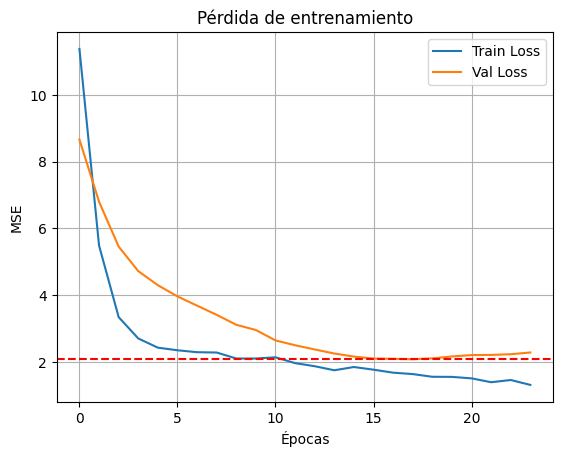

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.title("Pérdida de entrenamiento")
plt.legend()
best_val = min(history.history['val_loss'])
plt.axhline(y=best_val, color='r', linestyle='--', label=f"Best Val Loss: {best_val:.4f}")
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(X_val_inputs).flatten()

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
corr, _ = pearsonr(y_val, y_pred)
print(f"Correlación: {corr:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Correlación: 0.083
RMSE: 1.441
MAE:  1.205


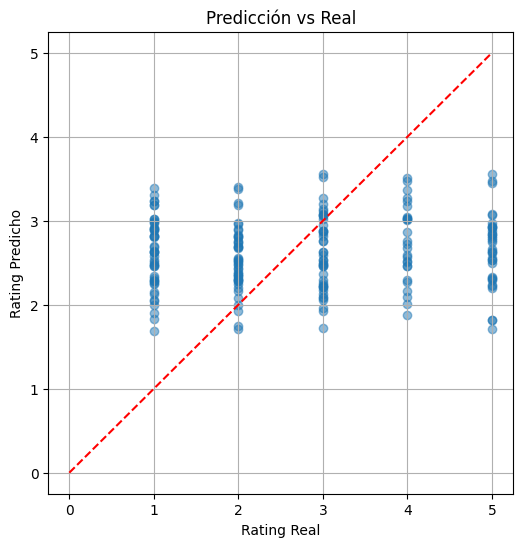

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel("Rating Real")
plt.ylabel("Rating Predicho")
plt.title("Predicción vs Real")
plt.grid(True)
plt.show()

In [ ]:
model.save("modelo_recomendador.keras")

In [ ]:
def obtener_perfil_usuario(user_id, df):
    user_data = df[df["UserID"] == user_id]
    if user_data.empty:
        print(f"⚠️ Usuario {user_id} no encontrado. Usando promedio general.")
        return df[num_cols].mean()
    return user_data[num_cols].mean()

In [ ]:
def recomendar_destinos_para_usuario(user_id, df, modelo, top_n=5):
    # Obtener destinos únicos
    destinos_unicos = df["DestinationID"].unique()

    # Crear un dataframe base para predicción
    user_df = pd.DataFrame({
        "UserID": [user_id] * len(destinos_unicos),
        "DestinationID": destinos_unicos
    })

    # Rellenar columnas numéricas con el perfil real del usuario
    perfil = obtener_perfil_usuario(user_id, df)
    for col in num_cols:
        user_df[col] = perfil[col]

    # Preparar inputs
    inputs = preparar_inputs(user_df)

    # Realizar predicciones
    predicciones = predict_with_clipping(modelo, inputs).flatten()
    user_df["PredictedRating"] = predicciones

    # Ordenar y retornar los mejores destinos
    recomendaciones = user_df.sort_values(by="PredictedRating", ascending=False).head(top_n)
    return recomendaciones[["DestinationID", "PredictedRating"]]

In [ ]:
recomendar_destinos_para_usuario(user_id=1, df=df, modelo=model)

,DestinationID,PredictedRating
2,4,3.568221
0,3,3.470503
1,0,3.383802
4,1,3.381391
3,2,3.362437
